## __Table of Contents:__

* [Section 1: Python Libraries and Data](#part1)
* [Section 2: Exploratory Data Analysis](#part2)
    * [Word Clouds](#part21)
    * [Sentiment Score Visualization](#part22)
    * [Entity Count Visualization](#part23)
    * [Correlation Plot](#part24)
* [Section 3: Machine-Learning for Misinformation Classification](#part3)
    * [Feature Selection and Normalization](#part31)
    * [Baseline Experiments](#part32)
    * [Ablation Studies](#part33)
    * [Using Silas for Comparison](#part34)

<a id='part1'></a>
## Section 1: Python Libraries and Data

In [4]:
%load_ext autoreload

import ast
import argparse
from bs4 import BeautifulSoup
import configparser
import csv
from collections import defaultdict

import dask.dataframe as dd
from dask.multiprocessing import get
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register

from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

import numpy as np
import os
import pandas as pd
import re
import requests
import sys
import time
import torch
from tqdm import tqdm
from urllib.parse import urlparse, urljoin, urldefrag
from urllib.request import urlopen
import validators

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.chrome.options import Options

from sentence_transformers import SentenceTransformer
from summarizer.sbert import SBertSummarizer
from transformers import pipeline

import warnings
warnings.filterwarnings("ignore")

# Pandas settings:
tqdm.pandas()
pd.options.display.max_rows = 50
pd.options.display.max_columns = 100

%autoreload 2 

# our own module imports:
from src.players import get_players_per_year, prepare_league_players
from src.players_values import get_players_values
from src.players_stats import get_players_stats
from src.team_stats import get_team_stats
from src.players_articles import get_all_forum_transfers, get_news_articles
from src.nlp_pipeline import get_summaries, get_sentiments, get_entities, get_embeddings
from src.utils import *

***
<a id='part2'></a>
## Section 2: Exploratory Data Analysis:

In [5]:
# Importing the dataframe
df = pd.read_pickle('data/majorleagues_20192021_combined.pkl')
df[list(df.select_dtypes(include='int').columns)] = df[list(df.select_dtypes(include='int').columns)].astype('int32')
df[list(df.select_dtypes(include='uint8').columns)] = df[list(df.select_dtypes(include='uint8').columns)].astype('int32')
df[list(df.select_dtypes(include='float64').columns)] = df[list(df.select_dtypes(include='float64').columns)].astype('float32')

In [6]:
# Doing some simple preprocessing:

df = df.drop(['summary', 'team_name_src', 'team_name_dst', 'article_date'], axis=1)
# One-hot encoding for categorical features
cat_cols = ["season", "player_foot", "position"]
dummy_df = pd.get_dummies(df[cat_cols], drop_first=True)

df = pd.concat([df, dummy_df], axis=1)
df = df.drop(cat_cols, axis=1)

In [7]:
# Getting value counts basically:
non_transfers = df[df["label"] == 0]
transfers = df[df["label"] == 1]
print(f"There are {non_transfers.shape[0]} non-transfers and {transfers.shape[0]} successful transfers in our dataset!")

There are 734 non-transfers and 909 successful transfers in our dataset!


<a id='part21'></a>
### The Classic Wordclouds

In [34]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

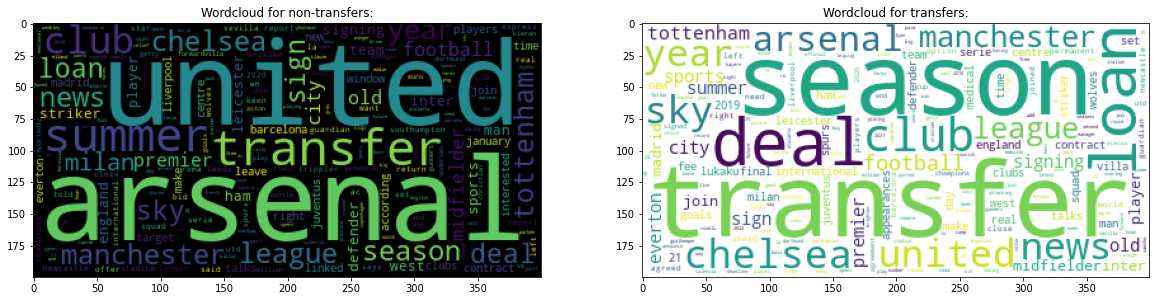

In [232]:
from sklearn.feature_extraction.text import TfidfVectorizer

# REFERENCE: https://towardsdatascience.com/how-to-make-word-clouds-in-python-that-dont-suck-86518cdcb61f
# Creating sensible wordclouds for non-transfer articles!
non_xfer_vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1,1), max_df = .6, min_df = .01)
non_xfer_X = non_xfer_vectorizer.fit_transform(non_transfers["summary"].values)
non_xfer_names = non_xfer_vectorizer.get_feature_names()
non_xfer_dense = non_xfer_X.todense()
non_xfer_list = non_xfer_dense.tolist()
non_xfer_df = pd.DataFrame(non_xfer_list, columns=non_xfer_names)
non_xfer_data = non_xfer_df.transpose()
wordcloud = WordCloud().generate_from_frequencies(non_xfer_data.sum(axis=1))

# Same for transfer articles!
vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1,1), max_df = .6, min_df = .01)
xfer_X = vectorizer.fit_transform(transfers["summary"].values)
xfer_names = vectorizer.get_feature_names()
xfer_dense = xfer_X.todense()
xfer_list = xfer_dense.tolist()
xfer_df = pd.DataFrame(xfer_list, columns=xfer_names)
xfer_data = xfer_df.transpose()
xfer_wordcloud = WordCloud(background_color="white").generate_from_frequencies(xfer_data.sum(axis=1))

# Plotting the wordclouds out!
fig, ax = plt.subplots(1,2,figsize=(20,15))
ax[0].imshow(wordcloud)
ax[0].set_title("Wordcloud for non-transfers:");
ax[1].imshow(xfer_wordcloud)
ax[1].set_title("Wordcloud for transfers:");

***
<a id='part22'></a>
### Understanding the relationship between Sentiment Scores and ground truth:

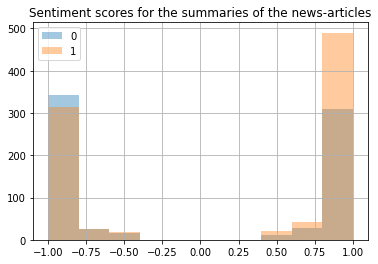

In [233]:
df.groupby("label").sentiment_score.hist(alpha=0.4, legend=True)
plt.title("Sentiment scores for the summaries of the news-articles");
# We can see that sentiment scores prove to be quite discriminative as a feature for capturing real transfer news.

***
<a id='part23'></a>
### Understanding the relationship between Entity Counts and ground truth:

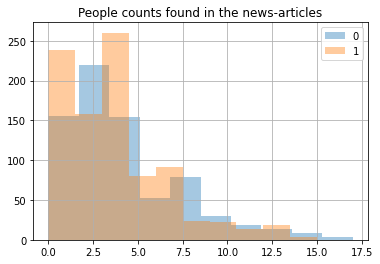

In [262]:
# Identifying counts of PERSON tag in articles:
df.groupby("label").people_count.hist(alpha=0.4, legend=True)
plt.title("People counts found in the news-articles"); # could be useful

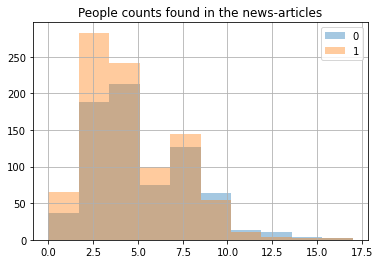

In [264]:
# Identifying counts of ORGANIZATION tag in articles:
df.groupby("label").org_count.hist(alpha=0.4, legend=True)
plt.title("People counts found in the news-articles"); # did not seem that useful unless the number of clubs mentioned was at the extreme right tail.

***
<a id='part24'></a>
### Correlation Plot:
We consider looking at the top 50 correlation features with regards to the ground truth labels for our dataset:

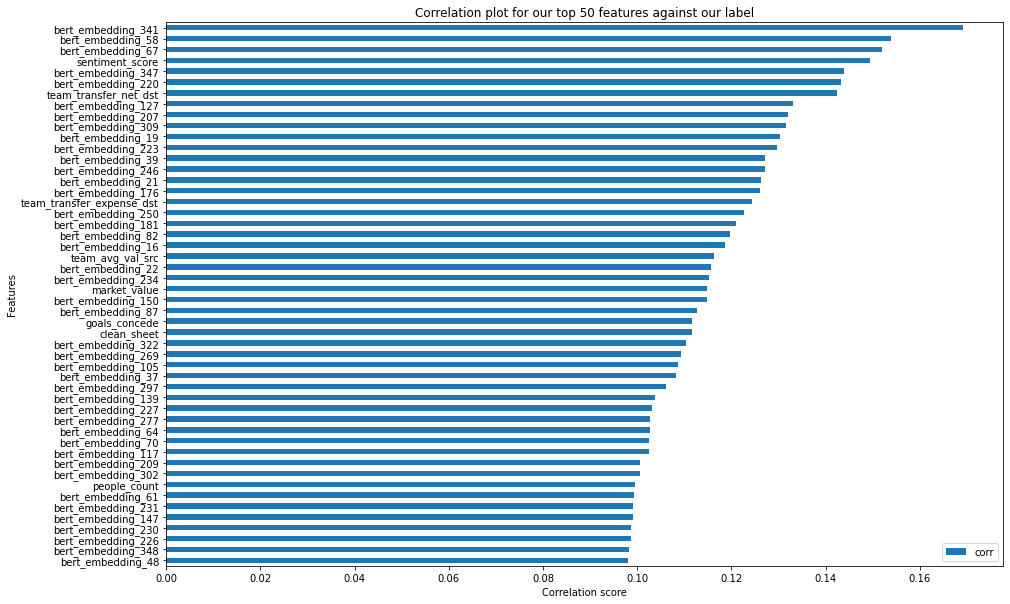

In [266]:
# SOURCE: https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

def get_feature_correlation(df, top_n=None, corr_method='spearman',
                            remove_duplicates=True, remove_self_correlations=True):
    """
    Compute the feature correlation and sort feature pairs based on their correlation

    :param df: The dataframe with the predictor variables
    :type df: pandas.core.frame.DataFrame
    :param top_n: Top N feature pairs to be reported (if None, all of the pairs will be returned)
    :param corr_method: Correlation compuation method
    :type corr_method: str
    :param remove_duplicates: Indicates whether duplicate features must be removed
    :type remove_duplicates: bool
    :param remove_self_correlations: Indicates whether self correlations will be removed
    :type remove_self_correlations: bool

    :return: pandas.core.frame.DataFrame
    """
    corr_matrix_abs = df.corr(method=corr_method).abs()
    corr_matrix_abs_us = corr_matrix_abs.unstack()
    sorted_correlated_features = corr_matrix_abs_us \
        .sort_values(kind="quicksort", ascending=False) \
        .reset_index()

    # Remove comparisons of the same feature
    if remove_self_correlations:
        sorted_correlated_features = sorted_correlated_features[
            (sorted_correlated_features.level_0 != sorted_correlated_features.level_1)
        ]

    # Remove duplicates
    if remove_duplicates:
        sorted_correlated_features = sorted_correlated_features.iloc[:-2:2]

    # Create meaningful names for the columns
    sorted_correlated_features.columns = ['Feature 1', 'Feature 2', 'Correlation (abs)']

    if top_n:
        return sorted_correlated_features[:top_n]

    return sorted_correlated_features

def extract_features(row):
    if row["Feature 1"] == "label":
        return row["Feature 2"]
    elif row["Feature 2"] == "label":
        return row["Feature 1"]

df_corr = get_feature_correlation(df)
df_corr["label_feature"] = df_corr.apply(extract_features, axis=1)
df_corr.dropna(subset=["label_feature"], inplace=True)
df_corr = df_corr[["Correlation (abs)", "label_feature"]]

top_50 = df_corr.sort_values(by="Correlation (abs)", ascending=True).tail(50)
top_50.rename(columns={"Correlation (abs)": "corr", "label_feature": "feature"}, inplace=True)

ax = top_50.plot.barh(figsize=(15,10));
ax.set_yticklabels(top_50.feature);
ax.set_title("Correlation plot for our top 50 features against our label");
ax.set_xlabel("Correlation score");
ax.set_ylabel("Features");

Interestingly, we noted that `people_count` and `sentiment_score` were indeed in the top 50 correlated features with regards to our label. Generally speaking, we see that both our BERT embeddings and entity features prove to be rather useful.

***
<a id='part3'></a>
## Section 3: Machine-Learning for Misinformation Classification
<a id='part31'></a>
### Section 3.1: Feature Selection and Normalization

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle 

X = df.drop("label", axis=1)
y = df["label"]

# train-test-split for experiments:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# Feature normalization:
sc = StandardScaler()
X_train_vals = sc.fit_transform(X_train)
X_train = pd.DataFrame(X_train_vals, index=X_train.index, columns=X_train.columns)

X_test_vals = sc.transform(X_test)
X_test = pd.DataFrame(X_test_vals, index=X_test.index, columns=X_test.columns)

pickle.dump(sc, open('scaler.pkl','wb'))
sc = pickle.load(open('scaler.pkl','rb'))

In [11]:
print(X_train.shape) # we have 438 columns currently

(1396, 438)


We essentially want to remove features with low variance, and we achieve this with Recursive Feature Elimination with Cross Validation.

In [13]:
%%time

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
selector = RFECV(lr,cv=10)
selector.fit(X_train,y_train)

# getting optimal columns
optimized_columns = X_train.columns[selector.support_]
X_train_final = X_train[optimized_columns]
X_test_final = X_test[optimized_columns]

pd.concat([X_test_final, y_test], axis=1).to_csv("test.csv", index=False)
pd.concat([X_train_final, y_train], axis=1).to_csv("train.csv", index=False)

CPU times: user 13min 45s, sys: 2min 5s, total: 15min 51s
Wall time: 2min


In [17]:
print(X_train_final.shape) # we see that we have reduced the number of columns to 339

(1396, 339)


***
<a id='part32'></a>
### Section 3.2: Baseline Experiments
We train a few model families: LogisticRegression, Decision Trees, Random Forests and a simple MultiLayerPerceptron:

In [294]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Note that these serve as baselines and we used either defaults or sensible hyper-parameters
lr_clf = LogisticRegression(random_state=42)
dt_clf = DecisionTreeClassifier(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)
mlp_clf = MLPClassifier(hidden_layer_sizes=(256, 128, 64, 32),activation="relu",random_state=42)

skf = StratifiedKFold(n_splits=5, random_state=11, shuffle=True)

lr_cv = cross_val_score(lr_clf, X_train_final, y_train, cv=skf)
dt_cv = cross_val_score(dt_clf, X_train_final, y_train, cv=skf)
rf_cv = cross_val_score(rf_clf, X_train_final, y_train, cv=skf)
mlp_cv = cross_val_score(mlp_clf, X_train_final, y_train, cv=skf)

In [295]:
print("These are scores for 5-fold cross validation:")
print(f"The 5-fold CV average score for Logistic Regression is: {lr_cv.mean()}")
print(f"The 5-fold CV average score for Decision Trees is: {dt_cv.mean()}")
print(f"The 5-fold CV average score for RandomForest is: {rf_cv.mean()}")
print(f"The 5-fold CV average score for Multi-Layer Perceptrons is: {mlp_cv.mean()}")

These are scores for 5-fold cross validation:
The 5-fold CV average score for Logistic Regression is: 0.8230824372759857
The 5-fold CV average score for Decision Trees is: 0.7844137224782386
The 5-fold CV average score for RandomForest is: 0.8295058883768561
The 5-fold CV average score for Multi-Layer Perceptrons is: 0.8502867383512545


In [283]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

lr_clf.fit(X_train_final, y_train)
dt_clf.fit(X_train_final, y_train)
rf_clf.fit(X_train_final, y_train)
mlp_clf.fit(X_train_final, y_train)

lr_pred = lr_clf.predict(X_test_final)
dt_pred = dt_clf.predict(X_test_final)
rf_pred = rf_clf.predict(X_test_final)
mlp_pred = mlp_clf.predict(X_test_final)

print("These are the accuracy scores on the test-set")
print(f"Accuracy score on test-set for Logistic Regression: {accuracy_score(y_test, lr_pred)}")
print(f"Accuracy score on test-set for Decision Tree: {accuracy_score(y_test, dt_pred)}")
print(f"Accuracy score on test-set for Random Forest: {accuracy_score(y_test, rf_pred)}")
print(f"Accuracy score on test-set for Multi-Layer Perceptrons: {accuracy_score(y_test, mlp_pred)}")

print("=================================")
print("These are the F1 scores on the test-set")
print(f"F1 score on test-set for Logistic Regression: {f1_score(y_test, lr_pred)}")
print(f"F1 score on test-set for Decision Tree: {f1_score(y_test, dt_pred)}")
print(f"F1 score on test-set for Random Forest: {f1_score(y_test, rf_pred)}")
print(f"F1 score on test-set for Multi-Layer Perceptrons: {f1_score(y_test, mlp_pred)}")

# print("=================================")
# print(classification_report(y_test, rf_pred))

These are the accuracy scores on the test-set
Accuracy score on test-set for Logistic Regression: 0.8502024291497976
Accuracy score on test-set for Decision Tree: 0.8016194331983806
Accuracy score on test-set for Random Forest: 0.8582995951417004
Accuracy score on test-set for Multi-Layer Perceptrons: 0.902834008097166
These are the F1 scores on the test-set
F1 score on test-set for Logistic Regression: 0.8710801393728222
F1 score on test-set for Decision Tree: 0.8304498269896193
F1 score on test-set for Random Forest: 0.8754448398576512
F1 score on test-set for Multi-Layer Perceptrons: 0.9166666666666666


***
<a id='part33'></a>
### Section 3.3: Ablation Studies:
Now what if we used only textual features, will we do worse?

In [298]:
text_cols = [col for col in X_train_final.columns if 'bert_embedding' in col]

X_text = X_train_final[text_cols]
X_text_test = X_test_final[text_cols]

We repeat the same as above, but we do this for datasets containing textual features only:

In [299]:
# Note that these serve as baselines and we used either defaults or sensible hyper-parameters
lr_clf = LogisticRegression(random_state=42)
dt_clf = DecisionTreeClassifier(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)
mlp_clf = MLPClassifier(hidden_layer_sizes=(256, 128, 64, 32),activation="relu",random_state=42)

skf = StratifiedKFold(n_splits=5, random_state=11, shuffle=True)

lr_cv = cross_val_score(lr_clf, X_text, y_train, cv=skf)
dt_cv = cross_val_score(dt_clf, X_text, y_train, cv=skf)
rf_cv = cross_val_score(rf_clf, X_text, y_train, cv=skf)
mlp_cv = cross_val_score(mlp_clf, X_text, y_train, cv=skf)

print("These are scores for 5-fold cross validation with \033[91m TEXT FEATURES ONLY: \033[0m")
print(f"The 5-fold CV average score for Logistic Regression is: {lr_cv.mean()}")
print(f"The 5-fold CV average score for Decision Trees is: {dt_cv.mean()}")
print(f"The 5-fold CV average score for RandomForest is: {rf_cv.mean()}")
print(f"The 5-fold CV average score for Multi-Layer Perceptrons is: {mlp_cv.mean()}")

lr_clf.fit(X_text, y_train)
dt_clf.fit(X_text, y_train)
rf_clf.fit(X_text, y_train)
mlp_clf.fit(X_text, y_train)

lr_pred = lr_clf.predict(X_text_test)
dt_pred = dt_clf.predict(X_text_test)
rf_pred = rf_clf.predict(X_text_test)
mlp_pred = mlp_clf.predict(X_text_test)
print("=================================")
print("These are the accuracy scores on the test-set \033[91m WITH TEXT FEATURES ONLY: \033[0m")
print(f"Accuracy score on test-set for Logistic Regression: {accuracy_score(y_test, lr_pred)}")
print(f"Accuracy score on test-set for Decision Tree: {accuracy_score(y_test, dt_pred)}")
print(f"Accuracy score on test-set for Random Forest: {accuracy_score(y_test, rf_pred)}")
print(f"Accuracy score on test-set for Multi-Layer Perceptrons: {accuracy_score(y_test, mlp_pred)}")

print("=================================")
print("These are the F1 scores on the test-set \033[91m WITH TEXT FEATURES ONLY: \033[0m")
print(f"F1 score on test-set for Logistic Regression: {f1_score(y_test, lr_pred)}")
print(f"F1 score on test-set for Decision Tree: {f1_score(y_test, dt_pred)}")
print(f"F1 score on test-set for Random Forest: {f1_score(y_test, rf_pred)}")
print(f"F1 score on test-set for Multi-Layer Perceptrons: {f1_score(y_test, mlp_pred)}")


These are scores for 5-fold cross validation with  TEXT FEATURES ONLY: 
The 5-fold CV average score for Logistic Regression is: 0.7865386584741423
The 5-fold CV average score for Decision Trees is: 0.7313978494623655
The 5-fold CV average score for RandomForest is: 0.8037301587301589
The 5-fold CV average score for Multi-Layer Perceptrons is: 0.841679467485919
These are the accuracy scores on the test-set  WITH TEXT FEATURES ONLY: 
Accuracy score on test-set for Logistic Regression: 0.8218623481781376
Accuracy score on test-set for Decision Tree: 0.7611336032388664
Accuracy score on test-set for Random Forest: 0.8785425101214575
Accuracy score on test-set for Multi-Layer Perceptrons: 0.8663967611336032
These are the F1 scores on the test-set  WITH TEXT FEATURES ONLY: 
F1 score on test-set for Logistic Regression: 0.8439716312056738
F1 score on test-set for Decision Tree: 0.7885304659498208
F1 score on test-set for Random Forest: 0.8958333333333334
F1 score on test-set for Multi-Layer P

***
<a id='part34'></a>
### Section 3.4: Using Silas for Comparisons:

In [33]:
cd silas_exec/
# We change working directory to silas exectuable for silas commands

/Users/kenghweeng/messiest_news/silas_exec


In [34]:
!silas gen-metadata-settings -o metadata-settings.json data/train.csv

         __ _ _           
        / _(_) | __ _ ___ 
        \ \| | |/ _` / __|
        _\ \ | | (_| \__ \
        \__/_|_|\__,_|___/

Silas v0.8.7+e
Copyright (c) 2018-2020 Dependable Intelligence Pty Ltd.
All rights reserved.

Please address your comments, bug reports and general inquiries about Silas to: support@depintel.com

-> Maximum concurrency: 16

[23:11:24] Generating metadata settings...
[23:11:24] Probing file: "data/train.csv"
[23:11:24] Writing metadata settings into: "metadata-settings.json"
[23:11:24] Done.


In [39]:
# print first 50 lines of metadata settings
!cat metadata-settings.json | head -n 50

{
    "missing-value-place-holders": [
        "",
        "NA",
        "na",
        " ",
        "?",
        "*",
        "NaN",
        "nan",
        "NULL",
        "Null",
        "null",
        "."
    ],
    "attribute-settings": [
        {
            "name": "sentiment_score",
            "type": "numerical"
        },
        {
            "name": "people_count",
            "type": "numerical"
        },
        {
            "name": "player_height",
            "type": "numerical"
        },
        {
            "name": "games",
            "type": "numerical"
        },
        {
            "name": "goals_concede",
            "type": "numerical"
        },
        {
            "name": "clean_sheet",
            "type": "numerical"
        },
        {
            "name": "assists",
            "type": "numerical"
        },
        {
            "name": "yellow",
            "type": "numerical"
        },
        {
            "name": "second_yellow",


In [35]:
!silas gen-metadata -o metadata.json metadata-settings.json data/train.csv

         __ _ _           
        / _(_) | __ _ ___ 
        \ \| | |/ _` / __|
        _\ \ | | (_| \__ \
        \__/_|_|\__,_|___/

Silas v0.8.7+e
Copyright (c) 2018-2020 Dependable Intelligence Pty Ltd.
All rights reserved.

Please address your comments, bug reports and general inquiries about Silas to: support@depintel.com

-> Maximum concurrency: 16

[23:12:06] Reading metadata settings from: "metadata-settings.json"
[23:12:06] Generating metadata ...
[23:12:06] Verifying dataset headers...
[23:12:06] Reading data from files...
[23:12:06] Creating json objects...
[23:12:06] Writing dataset statistics and metadata in: the current directory
[23:12:06] Done.


In [40]:
!cat metadata.json | head -n 50
# everything looks as expected.

{
    "attributes": [
        {
            "type": "numerical",
            "name": "sentiment_score",
            "data-type": "f32",
            "bounds": {
                "min": -1.158026806302359,
                "max": 0.9748880149994281
            }
        },
        {
            "type": "nominal",
            "name": "people_count",
            "ordered": false,
            "data-type": "u8",
            "values": [
                "-0.27007935561743546",
                "-0.610053007954622",
                "-0.9500266602918087",
                "-1.2900003126289952",
                "0.06989429671975118",
                "0.4098679490569378",
                "0.7498416013941244",
                "1.089815253731311",
                "1.4297889060684974",
                "1.7697625584056842",
                "2.1097362107428705",
                "2.4497098630800576",
                "2.789683515417244",
                "3.1296571677544307",
                "3.46963082009161

In [43]:
!silas sanitise -c new -n mean metadata-settings.json feature-stats.json metadata.json data/train.csv
# we generate the clean training dataset for downstream machine-learning

         __ _ _           
        / _(_) | __ _ ___ 
        \ \| | |/ _` / __|
        _\ \ | | (_| \__ \
        \__/_|_|\__,_|___/

Silas v0.8.7+e
Copyright (c) 2018-2020 Dependable Intelligence Pty Ltd.
All rights reserved.

Please address your comments, bug reports and general inquiries about Silas to: support@depintel.com

-> Maximum concurrency: 16

[23:19:53] Starting files sanitation...
[23:19:53] Sanitised datafile has been saved: data/clean-train.csv
[23:19:53] New metadata file has been saved: clean-metadata.json


In [44]:
!silas gen-settings -o settings.json -v cv clean-metadata.json data/clean-train.csv

         __ _ _           
        / _(_) | __ _ ___ 
        \ \| | |/ _` / __|
        _\ \ | | (_| \__ \
        \__/_|_|\__,_|___/

Silas v0.8.7+e
Copyright (c) 2018-2020 Dependable Intelligence Pty Ltd.
All rights reserved.

Please address your comments, bug reports and general inquiries about Silas to: support@depintel.com

-> Maximum concurrency: 16

[23:26:25] Generating machine learning settings ...
[23:26:25] Writing main settings in: settings.json
[23:26:25] Done.


In [ ]:
!gitignore the irrelevant files
!learn how to plot AUROC for test CSV

In [46]:
# we edit the settings.JSON to use 5-fold CV to compare experiments apple-to-apple.
!silas learn -o model/all_clf settings.json

         __ _ _           
        / _(_) | __ _ ___ 
        \ \| | |/ _` / __|
        _\ \ | | (_| \__ \
        \__/_|_|\__,_|___/

Silas v0.8.7+e
Copyright (c) 2018-2020 Dependable Intelligence Pty Ltd.
All rights reserved.

Please address your comments, bug reports and general inquiries about Silas to: support@depintel.com

-> Maximum concurrency: 16

[23:29:17] Settings has been read from: settings.json
[23:29:17] Metadata has been read from: clean-metadata.json
[23:29:18] Validation method: cross validation
[23:29:18] 1396 training instances have been loaded from: data/clean-train.csv
[23:29:18] ── Cross-validation ─ Run: 1, hold-out partition: 1 ──
[23:29:18] Timer(growing classifier) starts.
[23:29:18] [**************************************************] (100.00%)
[23:29:18] Timer(growing classifier) stops. Time elapsed: 123 (ms.)
[23:29:18] Computing performance on hold-out data instances...
[23:29:18]    ───────────────────────────────────────────────
[23:29:18]            